# Classification of crack images & crack segmentation based on the classification results <br>
<br>
 Group : 14 
<br>
 Member Name: Jerry Paul Varghese 
<br>
 Matriculation number: 453553 


# Part 1: Classification of Crack Images

In [10]:
## import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, r2_score
import tensorflow as tf
from PIL import Image, ImageDraw
import IPython.display as display
import random
import numpy as np

# Define directories
pos_dir = Path(r"C:\Users\jPaul\Positive")
neg_dir = Path(r"C:\Users\jPaul\Negative")

def create_dataframe(img_dir, label):
    filepaths = pd.Series(list(img_dir.glob(r'*.jpg')), name='Filepath', dtype='object').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

# Generate dataframes
pos_df = create_dataframe(pos_dir, 'POSITIVE')
neg_df = create_dataframe(neg_dir, 'NEGATIVE')

# Concatenate both positive and negative dataframes
full_df = pd.concat([pos_df, neg_df], axis=0).sample(frac=1, random_state=1).reset_index(drop=True)

# Splitting into train and rest (validation + test)
train_set, rest_set = train_test_split(full_df, train_size=0.8, random_state=1)

# Splitting the rest into validation and test
val_set, test_set = train_test_split(rest_set, train_size=0.75, random_state=1)

# Print the size of each set
print("Train set size:", len(train_set))
print("Validation set size:", len(val_set))
print("Test set size:", len(test_set))

# Loading Image Data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(train_set, 
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    target_size=(120, 120), 
                                                    color_mode='rgb',
                                                    class_mode='binary',
                                                    batch_size=32,
                                                    shuffle=True)

val_generator = train_datagen.flow_from_dataframe(val_set, 
                                                  x_col='Filepath',
                                                  y_col='Label',
                                                  target_size=(120, 120), 
                                                  color_mode='rgb',
                                                  class_mode='binary',
                                                  batch_size=32,
                                                  shuffle=False)

test_generator = test_datagen.flow_from_dataframe(test_set, 
                                                  x_col='Filepath',
                                                  y_col='Label',
                                                  target_size=(120, 120), 
                                                  color_mode='rgb',
                                                  class_mode='binary',
                                                  batch_size=32,
                                                  shuffle=False)

Train set size: 32000
Validation set size: 6000
Test set size: 2000
Found 32000 validated image filenames belonging to 2 classes.
Found 6000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 59, 59, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 28, 28, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 26, 26, 128)       7385

Test Loss: 0.00616
Test Accuracy: 99.85%
63/63 [==============================] - 5s 85ms/step


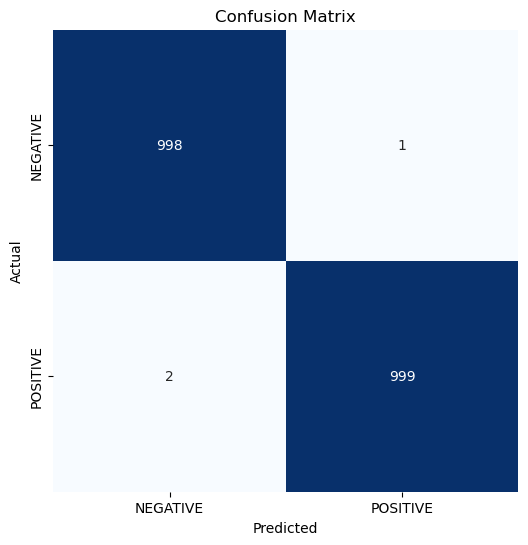

R2 Score: 0.993999993999994

Classification Report:
......................
               precision    recall  f1-score   support

    NEGATIVE       1.00      1.00      1.00       999
    POSITIVE       1.00      1.00      1.00      1001

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [11]:
# Define the model with convolutional layers and dropout
input_img = tf.keras.Input(shape=(120, 120, 3))

conv_layer_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(input_img)
pool_layer_1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv_layer_1)

conv_layer_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(pool_layer_1)
pool_layer_2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv_layer_2)

conv_layer_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(pool_layer_2)
pool_layer_3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv_layer_3)

conv_layer_4 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(pool_layer_3)
pool_layer_4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv_layer_4)

flatten_layer = tf.keras.layers.Flatten()(pool_layer_4)
dense_layer = tf.keras.layers.Dense(512, activation='relu')(flatten_layer)
dropout_layer = tf.keras.layers.Dropout(0.5)(dense_layer)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dropout_layer)

cnn_model = tf.keras.Model(inputs=input_img, outputs=output)
cnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Print model summary
cnn_model.summary()

# Train the model
training_history = cnn_model.fit(train_generator, validation_data=val_generator, epochs=14, 
                                 callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                             patience=3,
                                                                             restore_best_weights=True)])

# Plot the training and validation loss over time
fig = px.line(training_history.history, y=['loss', 'val_loss'], labels={'index':'Epoch'}, title='Training and Validation Loss over Time')
fig.show()

def assess_model(model, test_data):
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    accuracy = results[1]

    print(f'Test Loss: {loss:.5f}')
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

    # Predicted y values
    predictions = np.squeeze((model.predict(test_data) >= 0.5).astype(int))
    confidences = np.squeeze(model.predict(test_data)).round(6)

    confusion = confusion_matrix(test_data.labels, predictions)
    report = classification_report(test_data.labels, predictions, target_names=['NEGATIVE', 'POSITIVE'])

    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion, fmt='g', annot=True, cbar=False, vmin=0, cmap='Blues')
    plt.xticks(ticks=np.arange(2) + 0.5, labels=['NEGATIVE', 'POSITIVE'])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=['NEGATIVE', 'POSITIVE'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print('R2 Score:', r2_score(test_data.labels, predictions))
    print()
    print('Classification Report:\n......................\n', report)

assess_model(cnn_model, test_generator)

Found 1 validated image filenames belonging to 1 classes.
1/1 [==============================] - 0s 30ms/step


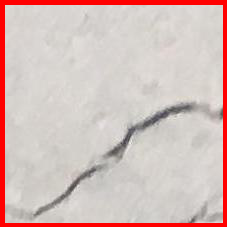

Test Image: Positive (Crack) (Confidence: 1.000000)


In [19]:
def evaluate_random_image(data_generator, model):
    # Select a random test image from the DataFrame
    random_index = random.randint(0, len(test_set) - 1)
    single_image_gen = data_generator.flow_from_dataframe(test_set.iloc[[random_index]], 
                                                          x_col='Filepath',
                                                          y_col='Label',
                                                          target_size=(120, 120), 
                                                          color_mode='rgb',
                                                          batch_size=1,
                                                          shuffle=False,
                                                          seed=42)
    
    image_path = test_set.iloc[random_index]['Filepath']
    image = Image.open(image_path)
    
    # Predict y value
    prediction = (model.predict(single_image_gen) >= 0.5).astype(int)[0, 0]
    confidence = model.predict(single_image_gen)[0, 0].round(6)

    result = 'Positive (Crack)' if prediction == 1 else 'Negative (Not Crack)'
    
    # Visualize the image with potential crack highlighting
    draw = ImageDraw.Draw(image)
    if prediction == 1:  # If crack is detected, draw a bounding box or mark it in some way
        draw.rectangle([(0, 0), image.size], outline='red', width=5)
    
    display.display(image)
    print(f"Test Image: {result} (Confidence: {confidence:.6f})")

# Already defined and trained the 'cnn_model'
evaluate_random_image(test_datagen, cnn_model)
